# Prise en main des concepts du Deep Learning

<br/>

##### Arnaud Deleruyelle : Doctorant SIGMA - BioComputing
##### Encadrement: John Klein (SIGMA) - Cristian Versari (BioComputing)

## Partie 1 : Initialisation du code

Nous allons traiter ce travail à l'aide de la bibliothèque Tensorflow de Google. 
Cette partie va se consacrer à la gestion des imports, la création des données etc...

### Section 1.1: Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import sin

### Section 1.2: Création d'un dataset artificiel

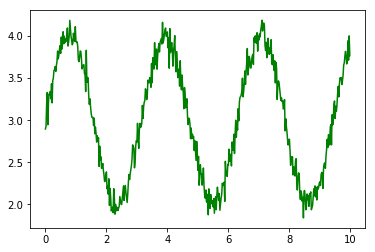

In [2]:
# dataset

def f(x): return sin(2*x) + 3
x_vals = np.arange(0, 10, 0.02)
y_vals = np.array([f(x) + np.random.normal(0, 0.1) for x in x_vals])

plt.plot(x_vals,y_vals, 'green')
plt.show()


### Section 1.3: Variables Globales

In [3]:
epochs = 10000
batch_size = 100

x = tf.placeholder(shape=[None, 1], dtype=tf.float64, name='x')
y = tf.placeholder(shape=[None, 1], dtype=tf.float64, name='y')

### Section 1.4: Fit

In [4]:
def Fit(x_vals,y_vals,model):
    sess = tf.Session()
    init_vars = tf.variables_initializer(tf.global_variables())
    sess.run(init_vars)
    for epoch in range(epochs):
        indices = np.random.choice(x_vals.shape[0], size=batch_size)
        x_batch = x_vals[indices].reshape((-1,1))
        x_batch = np.hstack([x_batch])
        y_batch = y_vals[indices].reshape((-1,1))
        feed_dict = {x: x_batch, y: y_batch}
        sess.run(model, feed_dict=feed_dict)
        if epoch%200==0:
            print("Loss = ", sess.run(avg_llh, feed_dict=feed_dict))
    return sess

### Section 1.5: Predict

In [5]:
def Predict(x_vals,session):
    x_batch = np.hstack([x_vals.reshape((-1,1))])
    feed_dict = {x: x_batch}
    yh_vals = session.run((y_pred), feed_dict=feed_dict)
    return yh_vals

    

### Section 1.6: Test d'un modèle

In [6]:
# first layer
A1 = tf.Variable(np.random.rand(1,8), dtype=tf.float64)
b1 = tf.Variable(np.random.rand(8), dtype=tf.float64)
l1_out = tf.tanh(tf.matmul(x, A1) + b1)

# second layer
A2 = tf.Variable(np.random.rand(8,8), dtype=tf.float64)
b2 = tf.Variable(np.random.rand(8), dtype=tf.float64)
l2_out = tf.tanh(tf.matmul(l1_out, A2) + b2)

# third layer
A3 = tf.Variable(np.random.rand(8,1), dtype=tf.float64)
b3 = tf.Variable(np.random.rand(1), dtype=tf.float64)
l3_out = tf.matmul(l2_out, A3) + b3

# output layer
y_pred = l3_out

# loss function
loglikelihoods = tf.square(y_pred - y)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
model = opt.minimize(avg_llh)

In [7]:
# fit the model
modelFit = Fit(x_vals,y_vals,model)

Loss =  3.2858845659807634
Loss =  0.48736619000718995
Loss =  0.5057133397154093
Loss =  0.3833023637269731
Loss =  0.46178652404505516
Loss =  0.2794480972152611
Loss =  0.3533163978412312
Loss =  0.29659781501788773
Loss =  0.23502336114983902
Loss =  0.2509990050978207
Loss =  0.21683572054603112
Loss =  0.2463316928163298
Loss =  0.18872614959601777
Loss =  0.21265983462046859
Loss =  0.09350400329154195
Loss =  0.09329510453905687
Loss =  0.06551397728986347
Loss =  0.044186720573963
Loss =  0.08139002772663458
Loss =  0.09101429134483591
Loss =  0.07854123150506004
Loss =  0.0469004475522622
Loss =  0.05492361592287672
Loss =  0.06724610306020697
Loss =  0.05945011409510454
Loss =  0.018275069711176907
Loss =  0.013043702463099414
Loss =  0.011271144500352175
Loss =  0.010477188344746091
Loss =  0.008460161779707055
Loss =  0.018329806747740148
Loss =  0.007511068201972432
Loss =  0.009981093395985258
Loss =  0.009632501966030717
Loss =  0.01228456920033561
Loss =  0.01108071279

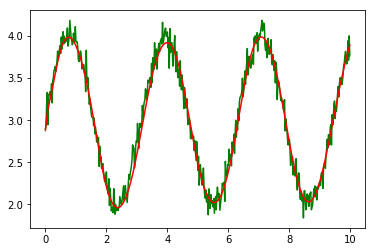

In [8]:
# predict 
modelPredict = Predict(x_vals,modelFit)

plt.plot(x_vals,y_vals, 'green')
plt.plot(x_vals,modelPredict, 'red')
plt.show()

## Partie 2: Utilisation des différentes fonctions d'activation.

Dans cette partie, nous allons étudier les 4 fonctions d'activation (Relu, sigmoide, tanh, identité).
Pour ce faire, nous avons choisi un optimiseur (SGD avec momentum) de manière à ne changer que la couche d'activation.